* Based on http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* Anton Karazeev, you can text me: [```anton.karazeev@gmail.com```](mailto:anton.karazeev@phystech.edu) or [t.me/akarazeev](https://t.me/akarazeev)


Reinforcement Learning (DQN) tutorial
=====================================
**Author**: `Adam Paszke <https://github.com/apaszke>`



**Task**

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, the environment terminates if the pole falls over too far.

**Packages**


First, let's import needed packages. Firstly, we need
`gym <https://gym.openai.com/docs>` for the environment
(Install using `pip install gym`).
We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)




In [1400]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable


env = gym.make('LunarLander-v2')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

[2017-11-05 12:51:27,069] Making new env: LunarLander-v2


Replay Memory
=======

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [1401]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let quickly recap what a DQN is.

DQN algorithm
=======

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the MSE loss.

Training
====

Hyperparameters and utilities
---------------------------
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``Variable`` - this is a simple wrapper around
   ``torch.autograd.Variable`` that will automatically send the data to
   the GPU every time we construct a Variable.
-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [1411]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x.view(x.size(0), -1)


BATCH_SIZE = 512
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.005
EPS_DECAY = 100

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state, model, exploration=True):
    global steps_done
    
    if exploration is False:
        # Testing case
        return model(
                Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        # Training case
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        if sample > eps_threshold:
            return model(
                Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
        else:
            return LongTensor([[random.randrange(4)]])


episode_rewards = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_rewards)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        

def preprocess_state(state):
    return torch.Tensor(state).unsqueeze(0).type(Tensor)

Training loop
=======

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state.



In [1412]:
last_sync = 0


def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))

    # We don't want to backprop through the expected action values and volatile
    # will save us on temporarily changing the model parameters'
    # requires_grad to False!
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute MSE loss
    loss = F.mse_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` variable. Then, we sample
an action, execute it, observe the next state and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes.



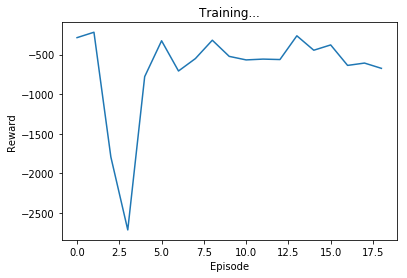

KeyboardInterrupt: 

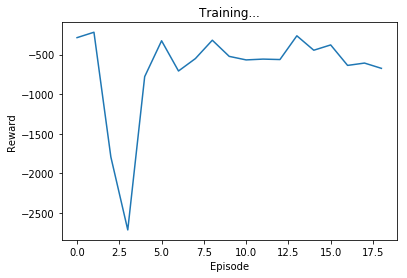

In [1413]:
num_episodes = 100
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = preprocess_state(state)

    total_reward = 0
    for t in count():
        # Select and perform an action
        action = select_action(state, model)
        next_state, reward, done, _ = env.step(action[0, 0])

        total_reward += reward

        next_state = preprocess_state(next_state)
        reward = Tensor([reward])

#         env.render()
        memory.push(state, action, next_state, reward)
        
        if done:
            next_state = None

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_rewards.append(total_reward)
            plot_durations()
            break

print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()
episode_durations = []

# AC

In [8]:
import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable


gamma = 0.99
seed = 543
log_interval = 10


env = gym.make('LunarLander-v2')
env.seed(seed)
torch.manual_seed(seed)


SavedAction = namedtuple('SavedAction', ['action', 'value'])
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(8, 128)
        self.action_head = nn.Linear(128, 4)
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores), state_values


model = Policy()
# optimizer = optim.Adam(model.parameters(), lr=3e-2)
optimizer = optim.Adam(model.parameters(), lr=0.01)


def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs, state_value = model(Variable(state))
    action = probs.multinomial()
    model.saved_actions.append(SavedAction(action, state_value))
    return action.data


def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    value_loss = 0
    rewards = []
    for r in model.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    for (action, value), r in zip(saved_actions, rewards):
        reward = r - value.data[0,0]
        action.reinforce(reward)
        value_loss += F.smooth_l1_loss(value, Variable(torch.Tensor([r])))
    optimizer.zero_grad()
    final_nodes = [value_loss] + list(map(lambda p: p.action, saved_actions))
    gradients = [torch.ones(1)] + [None] * len(saved_actions)
    autograd.backward(final_nodes, gradients)
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]


running_reward = 10
total_reward = 0
for i_episode in count(1):
    state = env.reset()
    
    for t in range(10000): # Don't infinite loop while learning
        action = select_action(state)
        state, reward, done, _ = env.step(action[0,0])
        total_reward += reward
        # if i_episode > 300:
        #     env.render()
        model.rewards.append(reward)
        if done:
            break

    running_reward = running_reward * 0.99 + t * 0.01
    finish_episode()
    if i_episode % log_interval == 0:
        print('Episode {}\tLast length: {:5d}\tAverage reward: {:.2f}'.format(
            i_episode, t, total_reward / log_interval))
        total_reward = 0

[2017-11-07 19:21:13,402] Making new env: LunarLander-v2


Episode 10	Last length:   113	Average reward: -285.31
Episode 20	Last length:    93	Average reward: -343.31
Episode 30	Last length:   176	Average reward: -667.78
Episode 40	Last length:    69	Average reward: -634.14
Episode 50	Last length:   114	Average reward: -674.28
Episode 60	Last length:    69	Average reward: -643.25
Episode 70	Last length:   150	Average reward: -623.36
Episode 80	Last length:   154	Average reward: -568.43
Episode 90	Last length:   217	Average reward: -303.04
Episode 100	Last length:   149	Average reward: -129.72
Episode 110	Last length:   133	Average reward: -169.73
Episode 120	Last length:   262	Average reward: -219.53
Episode 130	Last length:   126	Average reward: -90.23
Episode 140	Last length:   116	Average reward: -129.66
Episode 150	Last length:   143	Average reward: -94.51
Episode 160	Last length:   136	Average reward: -154.80
Episode 170	Last length:   129	Average reward: -120.28
Episode 180	Last length:   237	Average reward: -77.72
Episode 190	Last lengt

KeyboardInterrupt: 

In [18]:
env = gym.make('LunarLander-v2')
env2 = gym.make('LunarLander-v2')

for i_episode in count(1):
    state = env.reset()
    env2.reset()
    total_reward = 0
    for t in range(10000):
        action = select_action(state)
        state, reward, done, _ = env.step(action[0,0])
        env2.step(np.random.randint(4))
        
        env.render()
        env2.render()
        total_reward += reward
        if done:
            print(total_reward)
            break

[2017-11-07 19:26:50,947] Making new env: LunarLander-v2
[2017-11-07 19:26:50,957] Making new env: LunarLander-v2


-20.9963463406
-27.6007577435
134.102234544
16.3842251285
31.8511401825
77.3356597707


KeyboardInterrupt: 